In [11]:
import pandas as pd
import numpy as np

from nltk.stem import PorterStemmer
from nltk import sent_tokenize

from ast import literal_eval

In [2]:
import setup_modules
from lib.preprocessing import process, ngram_enhance, setup_enhance
from lib.fomc import get_lname

/home/bdurham/dev/fed-nlp


In [170]:
fomc = pd.read_csv('../working-csvs/fomc.csv', index_col=0)
dfs = pd.read_csv('../working-csvs/raw_transcripts_sectioned.csv', index_col=0)

In [4]:
sg = dfs.groupby(['date', 'speaker', 'section'])['content'].agg(" ".join).reset_index()

In [5]:
sg['sentences'] = sg['content'].map(sent_tokenize)
sg.drop(['content'], axis=1, inplace=True)
sgs = sg.explode('sentences')
sgs.rename(columns={'sentences': 'content'}, inplace=True)


In [102]:
sgs

,date,speaker,section,content
0,2007-01-31,CHAIRMAN BERNANKE.,1,"Seeing that there are no further questions, I ..."
0,2007-01-31,CHAIRMAN BERNANKE.,1,"Remember, we do have the two-handed option if ..."
0,2007-01-31,CHAIRMAN BERNANKE.,1,President Yellen.
0,2007-01-31,CHAIRMAN BERNANKE.,1,Thank you.
0,2007-01-31,CHAIRMAN BERNANKE.,1,President Moskow.
...,...,...,...,...
3391,2017-12-13,VICE CHAIRMAN DUDLEY.,2,So we do observe that inverted yield curves pr...
3391,2017-12-13,VICE CHAIRMAN DUDLEY.,2,"In this cycle, I expect the yield curve will c..."
3391,2017-12-13,VICE CHAIRMAN DUDLEY.,2,"But, to me, worrying now that we're committing..."
3391,2017-12-13,VICE CHAIRMAN DUDLEY.,2,Our tightening moves have not yet tightened ov...


In [103]:
bigrams, trigrams = setup_enhance('../ngrams/bigrams', '../ngrams/trigrams')
sgs['enhanced'] = sgs['content'].map(lambda x : ngram_enhance(x, bigrams, trigrams))

In [104]:
stemmer = PorterStemmer()
sgs['tokens'] = sgs['enhanced'].map(lambda x : process(x, stemmer=stemmer))

In [106]:
sgs.iloc[:10]

,date,speaker,section,content,enhanced,tokens
0,2007-01-31,CHAIRMAN BERNANKE.,1,"Seeing that there are no further questions, I ...","Seeing that there are no further questions, I ...","[see, question, propos, start, econom, go, rou..."
0,2007-01-31,CHAIRMAN BERNANKE.,1,"Remember, we do have the two-handed option if ...","Remember, we do have the two-handed option if ...","[rememb, two, hand, option, anyon, care, exercis]"
0,2007-01-31,CHAIRMAN BERNANKE.,1,President Yellen.,President Yellen.,"[presid, yellen]"
0,2007-01-31,CHAIRMAN BERNANKE.,1,Thank you.,Thank you.,[thank]
0,2007-01-31,CHAIRMAN BERNANKE.,1,President Moskow.,President Moskow.,"[presid, moskow]"
0,2007-01-31,CHAIRMAN BERNANKE.,1,I notice that they're not playing in the Seven...,I notice that they're not playing in the Seven...,"[notic, play, seventh, feder, reserv, district..."
0,2007-01-31,CHAIRMAN BERNANKE.,1,Thank you.,Thank you.,[thank]
0,2007-01-31,CHAIRMAN BERNANKE.,1,President Stern.,President Stern.,"[presid, stern]"
0,2007-01-31,CHAIRMAN BERNANKE.,1,Thank you.,Thank you.,[thank]
0,2007-01-31,CHAIRMAN BERNANKE.,1,President Minehan.,President Minehan.,"[presid, minehan]"


In [111]:
sgs['probs'] = sgs['tokens'].map(lambda x : ldamodel[dict.doc2bow(x)])

In [150]:
def topk_topics(topic_vec, k=3):
    # print(topic_vec[0][1])
    probs = [item[1] for item in topic_vec]
    probs.sort(reverse=True)
    threshold = probs[k - 1]
    topk = [item for item in topic_vec if item[1] >= max(threshold, 0.03)]
    rounded = [(topic, round(prob,4)) for topic, prob in topk]
    # print(topk)
    return rounded
topk_topics(sgs.iloc[0]['probs'])

[(22, 0.0745)]

In [152]:
sgs['topk'] = sgs['probs'].map(lambda x : topk_topics(x, k=3))

In [163]:
for i, row in sgs.sample(20)[['content', 'topk']].iterrows():
    if len(row['topk']) > 0:
        print(row['content'])
        print(row['topk'])

In fact, I believe that we should be working harder to return inflation to 2 percent over a reasonable horizon.
[(25, 0.0344)]
Meanwhile reserve balances have risen by more than $200 billion over the same period.
[(24, 0.0643), (28, 0.0478)]
Unfortunately, the more recent releases have been less encouraging, and financial markets are unsettled.
[(29, 0.0423)]
President Fisher.
[(22, 0.0336)]
I don't think I've looked at what the yield curve looks like in that situation.
[(28, 0.0398), (35, 0.0339)]
In particular, Brian was extraordinarily patient with me as he helped me get up to speed in learning all of the intricacies of Federal Reserve governance and communication, such as when I asked him, "So when we send a memo to the FOMC, what do we actually include in that memo?"
[(23, 0.0503), (24, 0.0471), (30, 0.0362)]
Turning to costs, I think there is a political risk associated with the scenario of ending remittances and booking a deferred asset while the interest on reserves that we pay

In [166]:
from transformers import pipeline
pipe = pipeline("text-classification", model="ProsusAI/finbert")

In [169]:
pipe(["testing", "terrible inflation plaguing the country"])

[{'label': 'neutral', 'score': 0.8503028154373169},
 {'label': 'negative', 'score': 0.9071136713027954}]

In [191]:
sgs = sgs.reset_index().drop(columns=['index'], axis=1)
sgs['sentiment'] = pipe(sgs['content'].tolist())

In [193]:
sgs.to_csv('sgs.csv')

In [162]:
sgs = pd.read_csv('sgs.csv', index_col=0)

In [163]:
for col in ['tokens', 'probs', 'topk', 'sentiment']:
    sgs[col] = sgs[col].apply(literal_eval)
sgs

,date,speaker,section,content,enhanced,tokens,probs,topk,sentiment
0,2007-01-31,CHAIRMAN BERNANKE.,1,"Seeing that there are no further questions, I ...","Seeing that there are no further questions, I ...","[see, question, propos, start, econom, go, rou...","[(0, 0.021269295), (1, 0.020457814), (2, 0.020...","[(22, 0.0745)]","{'label': 'neutral', 'score': 0.8389331102371216}"
1,2007-01-31,CHAIRMAN BERNANKE.,1,"Remember, we do have the two-handed option if ...","Remember, we do have the two-handed option if ...","[rememb, two, hand, option, anyon, care, exercis]","[(0, 0.02220238), (1, 0.020327553), (2, 0.0205...","[(22, 0.0342)]","{'label': 'neutral', 'score': 0.925499677658081}"
2,2007-01-31,CHAIRMAN BERNANKE.,1,President Yellen.,President Yellen.,"[presid, yellen]","[(0, 0.021790741), (1, 0.021789411), (2, 0.021...","[(20, 0.0374)]","{'label': 'neutral', 'score': 0.8563480973243713}"
3,2007-01-31,CHAIRMAN BERNANKE.,1,Thank you.,Thank you.,[thank],"[(0, 0.02222222), (1, 0.02222222), (2, 0.02222...",[],"{'label': 'neutral', 'score': 0.823481559753418}"
4,2007-01-31,CHAIRMAN BERNANKE.,1,President Moskow.,President Moskow.,"[presid, moskow]","[(0, 0.021786943), (1, 0.021786943), (2, 0.021...",[],"{'label': 'neutral', 'score': 0.9065612554550171}"
...,...,...,...,...,...,...,...,...,...
157206,2017-12-13,VICE CHAIRMAN DUDLEY.,2,So we do observe that inverted yield curves pr...,So we do observe that inverted yield curves pr...,"[observ, invert, yield, curv, preced, recess, ...","[(0, 0.020136476), (1, 0.01967466), (2, 0.0206...","[(28, 0.0372), (35, 0.0929)]","{'label': 'neutral', 'score': 0.8188691735267639}"
157207,2017-12-13,VICE CHAIRMAN DUDLEY.,2,"In this cycle, I expect the yield curve will c...","In this cycle, I expect the yield curve will c...","[cycl, expect, yield, curv, continu, flatten, ...","[(0, 0.02012715), (1, 0.01833055), (2, 0.03312...","[(6, 0.0374), (19, 0.0333), (28, 0.0482)]","{'label': 'negative', 'score': 0.9108558297157..."
157208,2017-12-13,VICE CHAIRMAN DUDLEY.,2,"But, to me, worrying now that we're committing...","But, to me, worrying now that we're committing...","[worri, commit, major, polici, mistak, rais, f...","[(0, 0.020601327), (1, 0.017746236), (2, 0.030...","[(3, 0.0552), (18, 0.0483), (20, 0.0366)]","{'label': 'negative', 'score': 0.8889493346214..."
157209,2017-12-13,VICE CHAIRMAN DUDLEY.,2,Our tightening moves have not yet tightened ov...,Our tightening moves have not yet tightened ov...,"[tighten, move, yet, tighten, overal, financi,...","[(0, 0.019499583), (1, 0.019107193), (2, 0.026...","[(28, 0.0365), (29, 0.062)]","{'label': 'neutral', 'score': 0.4787711203098297}"


In [164]:
sgs['sentlabel'] = sgs['sentiment'].map(lambda x : x['label']).map({'neutral': 0, 'positive': 1, 'negative': '-1'})
sgs['sentscore'] = sgs['sentiment'].map(lambda x : x['score'])

In [165]:
fsgs = sgs[(sgs['topk'].map(len) > 0) & (sgs['sentscore'] > 0.5) & (sgs['sentlabel'] != 0)]

In [166]:
k = 45

def partial_stance_vect(topics, sent_label):
    # print(topics)
    # maybe normalize
    total = sum([topic[1] for topic in topics])
    svect = [0] * k
    for topic, weight in topics:
        svect[topic] = float(sent_label) * float(weight) / total
    
    irrelevant =np.ones(45)
    irrelevant[4] = 0
    irrelevant[20] = 0
    irrelevant[22] = 0
    irrelevant[27] = 0 
    return np.array(svect) * irrelevant

In [167]:
fsgs.loc[:,'svect'] = fsgs.apply(lambda x : partial_stance_vect(x['topk'], x['sentlabel']), axis=1)

/tmp/ipykernel_6759/1640508726.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fsgs.loc[:,'svect'] = fsgs.apply(lambda x : partial_stance_vect(x['topk'], x['sentlabel']), axis=1)


In [168]:
fsgs.loc[:, 'speaker'] = fsgs['speaker'].map(get_lname)

In [171]:
fomc

,date,member,voter,pres,exp
0,2007-01-31,moskow,1,1,12.424658
1,2007-01-31,poole,1,1,8.865753
2,2007-01-31,geithner,1,1,3.208219
3,2007-01-31,minehan,1,1,12.561644
4,2007-01-31,hoenig,1,1,15.345205
...,...,...,...,...,...
1514,2017-12-13,bullard,0,1,9.706849
1515,2017-12-13,mullinix,0,1,0.701370
1516,2017-12-13,williams,0,1,6.791781
1517,2017-12-13,rosengren,0,1,10.408219


In [172]:
fsgs = fsgs.merge(fomc, how='left', left_on=['date', 'speaker'], right_on=['date', 'member'])

In [173]:
fsgs

,date,speaker,section,content,enhanced,tokens,probs,topk,sentiment,sentlabel,sentscore,svect,member,voter,pres,exp
0,2007-01-31,bernanke,1,I couldn't quite gather whether you were sayin...,I couldn't quite gather whether you were sayin...,"[quit, gather, whether, say, commerci, constru...","[(0, 0.020872911), (1, 0.03467562), (2, 0.0206...","[(1, 0.0347), (17, 0.0333)]","{'label': 'negative', 'score': 0.9363882541656...",-1,0.936388,"[0.0, -0.5102941176470588, 0.0, 0.0, 0.0, 0.0,...",bernanke,1.0,0.0,3.876712
1,2007-01-31,bernanke,1,"Labor markets remain taut, with continuing wag...","Labor markets remain taut, with continuing wag...","[labor, market, remain, taut, continu, wage, p...","[(0, 0.01998485), (1, 0.02154354), (2, 0.02495...","[(6, 0.0662), (10, 0.0466)]","{'label': 'negative', 'score': 0.967391848564148}",-1,0.967392,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.586879432624...",bernanke,1.0,0.0,3.876712
2,2007-01-31,bernanke,1,Consumption grew strongly in the fourth quarte...,Consumption grew strongly in the fourth quarte...,"[consumpt, grew, strongli, fourth, quarter, mo...","[(0, 0.018651297), (1, 0.02109584), (2, 0.0212...","[(10, 0.0595), (36, 0.0483)]","{'label': 'positive', 'score': 0.9580738544464...",1,0.958074,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",bernanke,1.0,0.0,3.876712
3,2007-01-31,bernanke,1,"Overall, investment seems likely to grow at a ...","Overall, investment seems likely to grow at a ...","[overal, invest, seem, like, grow, moder, pace...","[(0, 0.02071521), (1, 0.024362622), (2, 0.0217...","[(14, 0.0305), (17, 0.0337)]","{'label': 'positive', 'score': 0.9456616640090...",1,0.945662,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",bernanke,1.0,0.0,3.876712
4,2007-01-31,bernanke,1,"Housing, although a drag for now, does show so...","Housing, although a drag for now, does show so...","[hous, although, drag, show, tent, evid, stabil]","[(0, 0.020416306), (1, 0.031312995), (2, 0.022...","[(1, 0.0313)]","{'label': 'positive', 'score': 0.9454992413520...",1,0.945499,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",bernanke,1.0,0.0,3.876712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55805,2017-12-13,dudley,2,If the curve were to invert in the current env...,If the curve were to invert in the current env...,"[curv, invert, current, environ, would, peopl,...","[(0, 0.021819405), (1, 0.018863076), (2, 0.020...","[(6, 0.0309), (35, 0.0626)]","{'label': 'negative', 'score': 0.5716786980628...",-1,0.571679,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.330481283422...",dudley,1.0,1.0,8.882192
55806,2017-12-13,dudley,2,"Investors anticipate, if monetary policy is ti...","Investors anticipate, if monetary policy is ti...","[investor, anticip, monetari, polici, tight, e...","[(0, 0.022858093), (1, 0.020568505), (2, 0.021...","[(40, 0.0306)]","{'label': 'negative', 'score': 0.8797866106033...",-1,0.879787,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",dudley,1.0,1.0,8.882192
55807,2017-12-13,dudley,2,"In this cycle, I expect the yield curve will c...","In this cycle, I expect the yield curve will c...","[cycl, expect, yield, curv, continu, flatten, ...","[(0, 0.02012715), (1, 0.01833055), (2, 0.03312...","[(6, 0.0374), (19, 0.0333), (28, 0.0482)]","{'label': 'negative', 'score': 0.9108558297157...",-1,0.910856,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.314550042052...",dudley,1.0,1.0,8.882192
55808,2017-12-13,dudley,2,"But, to me, worrying now that we're committing...","But, to me, worrying now that we're committing...","[worri, commit, major, polici, mistak, rais, f...","[(0, 0.020601327), (1, 0.017746236), (2, 0.030...","[(3, 0.0552), (18, 0.0483), (20, 0.0366)]","{'label': 'negative', 'score': 0.8889493346214...",-1,0.888949,"[0.0, 0.0, 0.0, -0.39400428265524623, 0.0, 0.0...",dudley,1.0,1.0,8.882192


In [18]:
fsgs = fsgs[fsgs['voter'].notna()]

In [19]:
vdf = fsgs.groupby(['date', 'section', 'speaker'])[['svect','voter']].agg({'svect': 'sum', 'voter': 'max'}).reset_index()

In [20]:
tm = vdf[(vdf['date'] == '2008-06-25') & (vdf['voter'] == 1) & (vdf['section'] == 2)].copy()
tm.loc[:, 'fisher'] = tm['speaker'] == 'fisher'
tm.loc[:, 'avg_group'] = tm.groupby('fisher')['svect'].transform('mean')
tm.loc[:, 'diff_avg'] = tm.loc[:,'svect'] - tm.loc[:,'avg_group']
tm.loc[:, 'diff_norm'] = tm.loc[:,'diff_avg'].map(np.linalg.norm)
# 214, 219
np.linalg.norm(tm.loc[381, 'avg_group'] - tm.loc[384, 'avg_group'])
tm

,date,section,speaker,svect,voter,fisher,avg_group,diff_avg,diff_norm
381,2008-06-25,2,bernanke,"[0.0, 0.0, 0.0, 0.0, 0.0, -0.23350253807106597...",1.0,False,"[0.0, -0.08163866063533637, 0.0576956000684814...","[0.0, 0.08163866063533637, -0.0576956000684814...",2.021740
384,2008-06-25,2,fisher,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.35988483685220735,...",1.0,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.35988483685220735,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000
385,2008-06-25,2,geithner,"[0.0, -0.38077969174977333, 0.0, -1.0, 0.0, 0....",1.0,False,"[0.0, -0.08163866063533637, 0.0576956000684814...","[0.0, -0.29914103111443696, -0.057695600068481...",2.131501
387,2008-06-25,2,kohn,"[0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, -0.476470...",1.0,False,"[0.0, -0.08163866063533637, 0.0576956000684814...","[0.0, 0.08163866063533637, -0.0576956000684814...",2.074106
388,2008-06-25,2,kroszner,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.5233644859813085, ...",1.0,False,"[0.0, -0.08163866063533637, 0.0576956000684814...","[0.0, 0.08163866063533637, -0.0576956000684814...",1.824512
391,2008-06-25,2,mishkin,"[0.0, -0.353968253968254, 0.0, -0.456393442622...",1.0,False,"[0.0, -0.08163866063533637, 0.0576956000684814...","[0.0, -0.2723295933329176, -0.0576956000684814...",2.553171
392,2008-06-25,2,pianalto,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.58...",1.0,False,"[0.0, -0.08163866063533637, 0.0576956000684814...","[0.0, 0.08163866063533637, -0.0576956000684814...",1.361834
393,2008-06-25,2,plosser,"[0.0, 0.0, 0.5192604006163328, -0.410650887573...",1.0,False,"[0.0, -0.08163866063533637, 0.0576956000684814...","[0.0, 0.08163866063533637, 0.46156480054785143...",3.086151
395,2008-06-25,2,stern,"[0.0, 0.0, 0.0, 0.32646755921730175, 0.0, 0.0,...",1.0,False,"[0.0, -0.08163866063533637, 0.0576956000684814...","[0.0, 0.08163866063533637, -0.0576956000684814...",1.525993
396,2008-06-25,2,warsh,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,False,"[0.0, -0.08163866063533637, 0.0576956000684814...","[0.0, 0.08163866063533637, -0.0576956000684814...",1.044613


[0.274093   0.18916574]


[-0.34016787571910506,
 -1.4218781101263445,
 -0.047864273276409436,
 -0.16914569642767802,
 0.03143471724986504,
 -0.7468549306150842,
 -0.03665830767063272,
 3.0579414110249763,
 -0.24993702346497798,
 -0.07686991097460869]

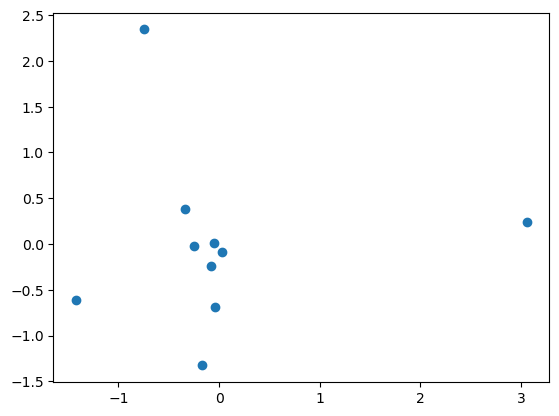

In [41]:
from sklearn.decomposition import PCA

X = tm['svect'].tolist()
y = tm['fisher'].map(int)


pca = PCA(n_components=2)
X_r = pca.fit_transform(X)

import matplotlib.pyplot as plt

X_r

X_r1 = [item[0] for item in X_r]
X_r2 = [item[1] for item in X_r]

plt.scatter(X_r1, X_r2)

print(pca.explained_variance_ratio_)
X_r1

In [273]:
from sklearn.cluster import KMeans

X = tm['svect'].map(lambda x: x.tolist())
X = np.array(X.tolist())
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
kmeans.predict(X)


/home/bdurham/miniconda3/envs/fed-nlp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1], dtype=int32)

In [59]:
tm2 = vdf[(vdf['date'] == '2008-06-25')]

In [160]:
tm2_1 = tm2[tm2['section'] == 1]#.sample(frac=1).reset_index(drop=True)
tm2_2 = tm2[tm2['section'] == 2] #.sample(frac=1).reset_index(drop=True)

X1 = tm2_1['svect'].tolist()[:15]
X2 = tm2_2['svect'].tolist()[:15]

X1_test = tm2_1['svect'].tolist()[15:]
X2_test = tm2_2['svect'].tolist()[15:]

pca1 = PCA(n_components=6)
pca2 = PCA(n_components=6)

# print(pca1.fit_transform(X1))

# print(pca2.fit_transform(X2))

# b, _, _, _ = np.linalg.lstsq(X1, X2)
# b
# X2_hat = X1 @ b

# print(pca1.fit_transform(X2)[2])
# print(pca2.fit_transform(X2_hat)[2])

X1_hat = pca1.fit_transform(X1)
X2_hat = pca2.fit_transform(X2)
# print(X2_hat)
# print(X2_hat.T)
np.corrcoef(X1_hat.T, X2_hat.T).round(2)
# np.corrcoef(X1_hat, X2_hat).round(3)


array([[ 1.  , -0.  , -0.  ,  0.  , -0.  ,  0.  ,  0.32,  0.07, -0.35,
        -0.33,  0.13,  0.45],
       [-0.  ,  1.  , -0.  ,  0.  ,  0.  , -0.  ,  0.23,  0.04, -0.37,
         0.17, -0.33,  0.13],
       [-0.  , -0.  ,  1.  ,  0.  ,  0.  ,  0.  , -0.61,  0.23, -0.21,
        -0.22, -0.32,  0.2 ],
       [ 0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  , -0.14, -0.21, -0.  ,
        -0.44, -0.02,  0.17],
       [-0.  ,  0.  ,  0.  ,  0.  ,  1.  , -0.  , -0.02,  0.3 ,  0.05,
         0.36,  0.41,  0.29],
       [ 0.  , -0.  ,  0.  ,  0.  , -0.  ,  1.  ,  0.07,  0.57, -0.1 ,
        -0.29,  0.28, -0.3 ],
       [ 0.32,  0.23, -0.61, -0.14, -0.02,  0.07,  1.  , -0.  ,  0.  ,
        -0.  , -0.  ,  0.  ],
       [ 0.07,  0.04,  0.23, -0.21,  0.3 ,  0.57, -0.  ,  1.  , -0.  ,
         0.  ,  0.  ,  0.  ],
       [-0.35, -0.37, -0.21, -0.  ,  0.05, -0.1 ,  0.  , -0.  ,  1.  ,
        -0.  ,  0.  ,  0.  ],
       [-0.33,  0.17, -0.22, -0.44,  0.36, -0.29, -0.  ,  0.  , -0.  ,
         1.  , -0.  

In [123]:
pca1.components_

array([[ 2.38441547e-02, -1.71819140e-01,  1.67127965e-02,
        -3.30167716e-03,  0.00000000e+00,  1.16521382e-02,
        -1.09040563e-01,  1.94365398e-02, -5.07702435e-01,
        -4.70459523e-02, -6.73775205e-01, -1.30122435e-03,
         1.78548913e-02,  1.44457016e-02, -2.59207508e-02,
        -9.89167716e-02, -9.66898511e-02,  1.48262835e-01,
         3.87348530e-02, -1.13771716e-01,  0.00000000e+00,
         4.07914739e-02,  0.00000000e+00,  3.39101276e-02,
         1.37299911e-01,  1.16577065e-01, -3.16401263e-02,
         0.00000000e+00, -1.10994049e-02, -3.23780602e-02,
        -1.08026108e-02, -3.82561847e-02, -2.15016560e-01,
        -5.54243374e-03,  2.27672912e-02,  6.81948447e-02,
         1.64379280e-01,  0.00000000e+00, -9.88195671e-02,
        -1.87075204e-01,  2.44997804e-02,  5.15902332e-02,
        -1.65797614e-02,  1.31080052e-02,  1.43442494e-01],
       [ 1.98913101e-02,  6.81036092e-02,  9.14715925e-03,
        -3.66159027e-02,  6.93889390e-17,  6.01660765e-

In [122]:
pca1 = PCA().fit(X1)
pca2 = PCA().fit(X2)

t1_to_2 = pca1.components_ @ pca2.components_.T

mapped = np.dot(X1[0], t1_to_2)

ValueError: shapes (45,) and (15,15) not aligned: 45 (dim 0) != 15 (dim 0)

PCA OF EACH SECTION MAPPED OVER EACH OTHER

In [65]:
tm2.groupby('speaker')['svect'].agg(lambda x : np.ptp(np.stack(x), axis=0)).map(np.linalg.norm)

speaker
bernanke     8.962066
bullard      4.279339
evans        4.435498
fisher       4.749515
geithner     5.489499
hoenig       3.567919
kohn         4.793015
kroszner     3.994971
lacker       5.061400
lockhart     5.175702
mishkin      4.096773
pianalto     2.972476
plosser      5.764321
rosengren    4.725355
stern        2.683315
warsh        4.093230
yellen       5.119964
Name: svect, dtype: float64

In [201]:
len(fsgs)

# COME BACK AND CHECK THIS

55810

In [198]:
fsgs['exp'].describe()

count    51016.000000
mean         5.431051
std          3.924087
min          0.000000
25%          2.268493
50%          4.898630
75%          7.750685
max         24.410959
Name: exp, dtype: float64

In [202]:
fsgs = fsgs[fsgs['exp'].notna()]

/tmp/ipykernel_6759/1611013365.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fsgs['inexp'] = fsgs['exp'] < fsgs.groupby('date')['exp'].transform(lambda x : np.percentile(x, 25))


In [206]:
fsgs['inexp'].value_counts()

inexp
False    39824
True     11192
Name: count, dtype: int64

In [209]:
ndf = fsgs.groupby(['date', 'section', 'speaker'])[['svect', 'voter', 'pres', 'exp']].agg({'svect': 'sum', 'voter': 'max', 'pres': 'max', 'exp': 'max'})

In [249]:
ndf.reset_index()
ndf['inexp'] = (ndf['exp'] < ndf.groupby('date')['exp'].transform(lambda x : np.percentile(x, 25))).map(int)

In [251]:
nrdf = ndf.reset_index()

nrdf.loc[0:16, 'svect'].map(lambda x : x[0]).agg('mean')

# nrdf[0:17]
nrdf['diff_avg'] = (nrdf['svect'] - nrdf.groupby(['date', 'section'])['svect'].transform('mean')).map(np.linalg.norm)
nrdf['inexp'].value_counts()

inexp
0    2188
1     690
Name: count, dtype: int64

In [253]:
nrdf[['section', 'exp', 'diff_avg', 'pres', 'voter']]

,section,exp,diff_avg,pres,voter
0,1,3.876712,4.496129,0.0,1.0
1,1,5.153425,4.254622,0.0,1.0
2,1,1.827397,2.736631,1.0,0.0
3,1,3.208219,2.525023,1.0,1.0
4,1,15.345205,1.901934,1.0,1.0
...,...,...,...,...,...
2873,2,5.556164,1.690131,0.0,1.0
2874,2,0.238356,2.459615,0.0,1.0
2875,2,10.408219,1.987225,1.0,0.0
2876,2,6.791781,2.514380,1.0,0.0


In [256]:
import statsmodels.api as sm

X = nrdf[['section', 'exp', 'pres', 'voter']]
y = nrdf[['diff_avg']]
model = sm.OLS(y, X)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               diff_avg   R-squared (uncentered):                   0.712
Model:                            OLS   Adj. R-squared (uncentered):              0.711
Method:                 Least Squares   F-statistic:                              1774.
Date:                Mon, 12 Feb 2024   Prob (F-statistic):                        0.00
Time:                        15:01:16   Log-Likelihood:                         -5907.9
No. Observations:                2878   AIC:                                  1.182e+04
Df Residuals:                    2874   BIC:                                  1.185e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
section       -0.0793      0.051     -1.546      0.122      -0.180       0.021
exp            0.0834      0.008     10.629      0.000       0.068       0.099
pres           1.9364      0.076     25.524      0.000       1.788       2.085
voter          1.8725      0.071     26.228      0.000       1.732       2.012
==============================================================================
Omnibus:                      305.251   Durbin-Watson:                   1.488
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              539.436
Skew:                           0.719   Prob(JB):                    7.30e-118
Kurtosis:                       4.559   Cond. No.                         19.2
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [261]:
import matplotlib.pyplot as plt

nrdf.groupby('date')['diff_avg'].agg('mean')

nrdf['date'] = pd.to_datetime(nrdf['date'])

date
2007-01-31    2.438744
2007-03-21    2.843450
2007-05-09    2.765708
2007-06-28    3.107107
2007-08-07    3.038269
                ...   
2017-06-14    3.185388
2017-07-26    2.987671
2017-09-20    3.185207
2017-11-01    3.512956
2017-12-13    3.043190
Name: diff_avg, Length: 88, dtype: float64